# This demo
This demo is meant to demonstrate the basic concepts of a federated learning approach. The task used for this demonstration is a very simple function estimation. The setups is very simplified, we wont use different hardware per node and won't train in parallel but sequentially.

In [162]:
### imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm
import copy
import random
from sklearn.model_selection import train_test_split

### Federated Leanring Hyperparameter
We will use an example in which we have three nodes. In reality $N$ is much larger, in ome cases $N$ is much larger than the amount of trainings data per node. For demonstration purposes $N=3$ will suffice.

In [209]:
### Hyperparameter federated learning

N = 30 # Number of nodes: Cross silo: 3; cross device: 30
C = 10 # Number of Nodes used per trainings round Cross silo: C=N ; cross device: 10

## Example task
We will use the most general task, a fully connected network can solve; function fitting. Since we focus on federated learning and not the network architecture, we will try to fit a very simple polynomial. in our case $f(x)=x^3-5x$.

In [198]:
### Parameter of Example

NOISE = True # add noise to trainings data
SHUFFLE = True # shuffle some elements between nodes randomly
SUPPORT = (-2.8, 2.8) # support of function
PITCH = 0.0075 # pitch between equally spaced samples: cross silo: 0.002; cross device: 0.01

Number of samples: 747


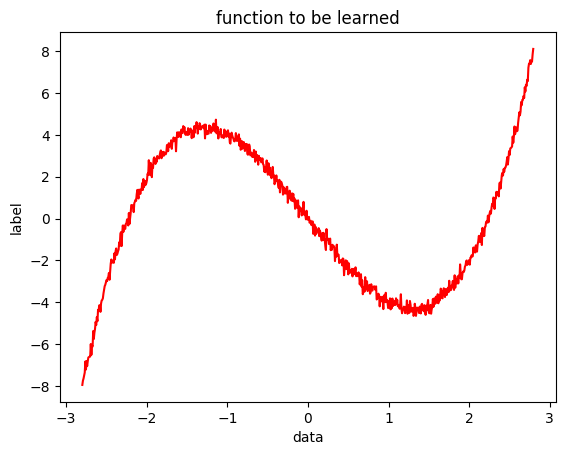

In [199]:
### Label generating function to be learned

def f (x):
  return x*x*x -5*x # simple polynomial of third degree

# plot function
data = np.arange(SUPPORT[0],SUPPORT[1],PITCH)
num_data = len(data)
print(f"Number of samples: {num_data}")
label = f(data)

# add label noise
if NOISE:
  add_noise = np.random.normal(0,0.2,data.shape) # The noise level can be modified.
  label+=add_noise

plt.plot(data, label, color='red')
plt.title("function to be learned")
plt.xlabel('data')
plt.ylabel('label')
plt.show()

## Data distribution
We now have data $(x,y)$ where $x$ is the data and $y$ the corresponding label. We now have to distribute the data across our nodes.

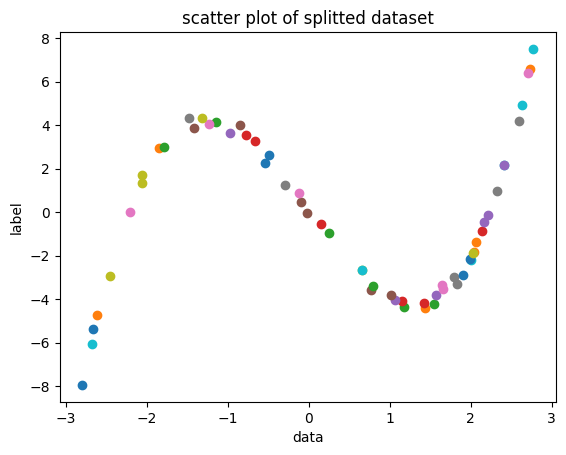

In [200]:
### create datasets

glob_dataset = np.hstack((data[:,np.newaxis], label[:,np.newaxis]))
indices = np.argsort(glob_dataset[:,1])
glob_dataset = np.asarray([(glob_dataset[i,0],glob_dataset[i,1]) for i in indices])

# shuffle
if SHUFFLE:
  for k in range((int)(0.1*len(glob_dataset))):
    a,b = np.random.randint(0,len(glob_dataset),2)
    tmp = glob_dataset[a]
    glob_dataset[a]=glob_dataset[b]
    glob_dataset[b]=glob_dataset[a]


# split dataset in N parts
split = np.array_split(glob_dataset, N)
for sub_set in split:
  plt.scatter(sub_set[::20,0],sub_set[::20,1], marker='o')
plt.title("scatter plot of splitted dataset")
plt.xlabel('data')
plt.ylabel('label')
plt.show()



## Non-IIDness of datasplit
An identically distributed split would mean, that each split would have been sampled from the same distribution. In this example this would translate to a uniform sampling of datapoints within the support of the function. This is equivalent to randomly assigning an equal amount of data, label pairs to the nodes.
This obviously is not the case here. Independent of the Node, since the underlying function is the same on each node, each $x$ is translated to roughly the same $y$ and vice versa. Thus $P_i(y|x)$ and $P_i(x|y)$ is the same for each Node, so we don't have a concept shift or drift. What does vary is the distribution of the labels $P_i(y)$ and the distribution of the feature $P_i(x)$, thus we do have a Prior and Covariance shift.

## Defining our model
After we have our function and split our data, we now need a model to approximate the function.
Here we will use a very simple feed forward network with two hidden layers and 16 neurons per hidden layer. Since a multiple times continuously differentiable function is approximated, a Sigmoid function is used as activation function.

In [201]:
### set hyper parameter

NEURONS_PER_LAYER = 16 # number of nodes in the hidden layer
RANDOM_SEED = 7 # seed for random initialization

In [202]:
### define two layer feed forward network

class FFN(nn.Module):
    def __init__(self,n, seed):
      super(FFN, self).__init__()
      torch.manual_seed(seed)
      self.fc1 = nn.Linear(1, n,True)
      self.sig1 = nn.Sigmoid()
      self.fc2 = nn.Linear(n,n,True)
      self.sig2 = nn.Sigmoid()
      self.fc3 = nn.Linear(n,1,False)


    def forward(self,x):

      x = self.fc1(x)
      x = self.sig1(x)
      x = self.fc2(x)
      x = self.sig2(x)
      x = self.fc3(x)

      return x

## test general ability to learn function
This is more or less only meant as a proof of the general ability of the model to fit the entire dataset. It is not connected to federated learning. As for all federated learning approaches, for simplicity we will not use any validation data.

In [ ]:
### test global model performance

glob_model = FFN(NEURONS_PER_LAYER, RANDOM_SEED)
glob_model.double()

# define training hyper parameter
loss_fn = nn.MSELoss()
optimizer = opt.SGD(glob_model.parameters(), lr=0.01, momentum=0.9)
NUM_EPOCHS  = 1500

## setup trainings pipeline

# Training function
def train(model, data, labels, max_epochs):
  epochs = []
  trainloss = []
  data = torch.from_numpy(data[:,np.newaxis])
  print(f"data size : {data.shape}")
  labels = torch.from_numpy(labels[:,np.newaxis])
  for epoch in tqdm(range(max_epochs)):
    epochs.append(epoch)
    optimizer.zero_grad()
    pred = model(data)
    loss = loss_fn(pred,labels)
    loss.backward()
    optimizer.step()
    trainloss.append(loss.detach().numpy())

  epochs = np.asarray(epochs)
  trainloss = np.asarray(trainloss)
  return epochs, trainloss

epochs, train_loss = train(glob_model,glob_dataset[:,0],glob_dataset[:,1],NUM_EPOCHS)

## plot training stats

# plot loss over epochs
plt.plot(epochs, train_loss, color='red')
plt.title("loss over epochs")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# plot prediction
data_test = np.arange(-3,3,0.005)
with torch.no_grad():
  y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))

y_exact = f(data_test)

plt.plot(data_test, y_pred.detach().numpy(), color='red')
plt.plot(data_test, f(data_test), color='green')
plt.title(f"Ground truth (green) vs. prediction (red)")
plt.xlabel('x')
plt.ylabel('y')
plt.show()




## Cross-silo Federated learning pipeline
This Experiment is meant to demonstrate a so-called cross silo federated learning approach. In this setting the number of trainings samples per node is much larger than the number of nodes. In our case roughly 1000 samples in each of the three nodes. Further we can assume all nodes to be reachable in each training round.

In [ ]:
### fed parameters

MAX_ROUNDS = 20 # number of federated learning rounds T
MAX_EPOCH = 1000 # number od epochs per round

In [ ]:
### cross silo federated learning pipeline

# params for visualization
RESUME_TO_ENDE=False

# init global model
glob_model = FFN(NEURONS_PER_LAYER, RANDOM_SEED)
glob_model.double()
loss_fn = nn.MSELoss()

# init local models
loc_models = []
loc_optimizers = []
for k in range(N):
  loc_models.append(FFN(NEURONS_PER_LAYER,10).double())
  loc_optimizers.append(opt.SGD(loc_models[k].parameters(), lr=0.01, momentum=0.9))

# prepare data
if type(split[0]) is np.ndarray:
  for k in range(N):
    split[k]=torch.from_numpy(split[k]) # needs to be a pytorch tensor

# define training function
def train(model, data, labels, opt, max_epochs):
  epochs = []
  trainloss = []
  for epoch in range(max_epochs):
    epochs.append(epoch)
    opt.zero_grad()
    pred = model(data)
    loss = loss_fn(pred,labels)
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().numpy())

  epochs = np.asarray(epochs)
  trainloss = np.asarray(trainloss)
  return epochs, trainloss

# test data for visualization
data_test = np.arange(-3,3,0.005)
y_exact = torch.from_numpy(f(data_test)[:,np.newaxis])
loss_glob = []
rounds = []

# start training rounds
for trainings_round in tqdm(range(MAX_ROUNDS)):#tqdm(range(MAX_ROUNDS)):

  rounds.append(trainings_round) # for easier visualization

  # 1. broadcast global model to local nodes
  for k in range(N):
    loc_models[k].load_state_dict(glob_model.state_dict())

  # 2. train local models
  nodes_epoch = []
  nodes_loss = []
  for loc_dataset, loc_model, loc_opt in zip(split,loc_models, loc_optimizers):

    loc_data = loc_dataset[:,0,None]
    loc_label = loc_dataset[:,1,None]

    loc_epochs, loc_trainloss = train(loc_model,loc_data,loc_label,loc_opt,MAX_EPOCH) # magic happens here

    nodes_epoch.append(loc_epochs)
    nodes_loss.append(loc_trainloss)

  # 3. aggregate models
  glob_sd = copy.deepcopy(glob_model.state_dict())
  loc_sds = []
  for k in range(N):
    loc_sds.append(loc_models[k].state_dict())

  # simply average weights
  for key in glob_sd.keys():
    glob_sd[key]= torch.multiply(glob_sd[key],0)
    for k in range(N):
      glob_sd[key] += torch.multiply(loc_sds[k][key], 1/N)

  # 4. update global model
  glob_model.load_state_dict(glob_sd)

  # calc glob loss
  with torch.no_grad():
    y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))
  round_loss = loss_fn(y_pred,y_exact)
  loss_glob.append(round_loss.detach().numpy())


  # print output
  if RESUME_TO_ENDE is False:
    verbose = input("show loss and prediction? [Y/N]")
    if verbose == 'Y' or verbose == 'y':
      for k, node_epoch, node_loss, loc_model, loc_dataset in zip(range(N),nodes_epoch,nodes_loss, loc_models, split):

        # plot loc dataset
        plt.scatter(loc_dataset[:,0], loc_dataset[:,1])
        plt.xlim(-3,3)
        plt.ylim(-12,12)
        plt.title(f"Dataset of Node {k} in round {trainings_round}")
        plt.xlabel('data')
        plt.ylabel('label')
        plt.show()

        # plot loss
        plt.plot(node_epoch, node_loss, color='red')
        plt.title(f"loss over epochs of Node {k} in round {trainings_round}")
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        # plot prediction
        with torch.no_grad():
          y_pred = loc_model(torch.from_numpy(data_test[:,np.newaxis]))

        plt.plot(data_test, y_pred.detach().numpy(), color='red')
        plt.plot(data_test, f(data_test), color='green')
        plt.title(f"prediction of Node {k} in round {trainings_round}")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
      # plot averaged prediction
      with torch.no_grad():
        y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))
      plt.plot(data_test, y_pred.detach().numpy(), color='red')
      plt.plot(data_test, f(data_test), color='green')
      plt.title(f"Prediction of glob model in round {trainings_round}")
      plt.xlabel('x')
      plt.ylabel('y')
      plt.show()


    resume = input("resume rest of rounds? [Y/N]")
    if resume == 'Y' or resume=='y':
      RESUME_TO_ENDE = True

# plot final performance data
with torch.no_grad():
  y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))
plt.plot(data_test, y_pred.detach().numpy(), color='red')
plt.plot(data_test, f(data_test), color='green')
plt.title(f"Prediction learned model")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(np.asarray(rounds),np.asarray(loss_glob))
plt.title(f"global loss over training rounds")
plt.xlabel('training rounds')
plt.ylabel('loss')
plt.show()






## cross device setting
For this setup, we need to change some hyperparameters. Since we want more nodes than samples per node we have to set N to 30 and the pitch to 0.01. to avoid too much copying of code

100%|██████████| 50/50 [02:07<00:00,  2.55s/it]


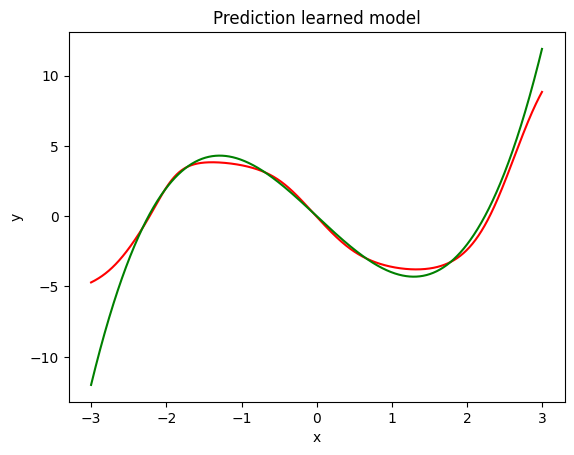

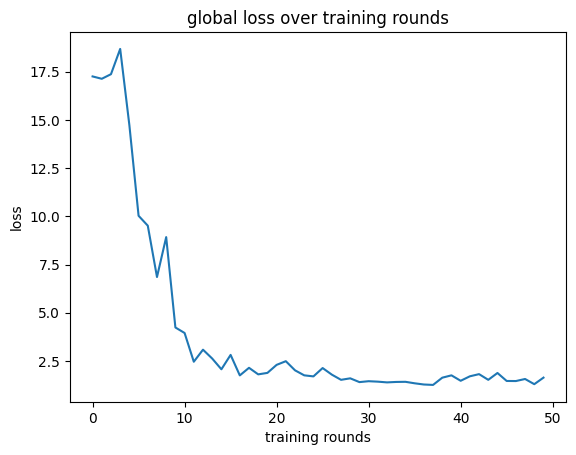

In [212]:
### cross device federated learning pipeline

# trainings params
MAX_ROUNDS = 50 # number of federated learning rounds T
MAX_EPOCH = 500 # number od epochs per round

# params for visualization
RESUME_TO_ENDE=True

# init global model
glob_model = FFN(NEURONS_PER_LAYER, RANDOM_SEED)
glob_model.double()
loss_fn = nn.MSELoss()

# init local models
loc_models = []
loc_optimizers = []
for k in range(N):
  loc_models.append(FFN(NEURONS_PER_LAYER,10).double())
  loc_optimizers.append(opt.SGD(loc_models[k].parameters(), lr=0.01, momentum=0.9))

# prepare data
if type(split[0]) is np.ndarray:
  for k in range(N):
    split[k]=torch.from_numpy(split[k]) # needs to be a pytorch tensor

# define training function
def train(model, data, labels, opt, max_epochs):
  epochs = []
  trainloss = []
  for epoch in range(max_epochs):
    epochs.append(epoch)
    opt.zero_grad()
    pred = model(data)
    loss = loss_fn(pred,labels)
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().numpy())

  epochs = np.asarray(epochs)
  trainloss = np.asarray(trainloss)
  return epochs, trainloss

# test data for visualization
data_test = np.arange(-3,3,0.005)
y_exact = torch.from_numpy(f(data_test)[:,np.newaxis])
loss_glob = []
rounds = []

# start training rounds
for trainings_round in tqdm(range(MAX_ROUNDS)):#tqdm(range(MAX_ROUNDS)):

  rounds.append(trainings_round) # for easier visualization

  # 1. select clients
  selection = random.sample(range(N),C)

  # 1. broadcast global model to local nodes
  for k in selection:
    loc_models[k].load_state_dict(glob_model.state_dict())

  # 2. train local models
  nodes_epoch = []
  nodes_loss = []
  loc_sds = []
  denom = 0
  for k in selection:

    # get data of selection
    loc_dataset = split[k]
    loc_model = loc_models[k]
    loc_opt = loc_optimizers[k]

    loc_data = loc_dataset[:,0,None]
    loc_label = loc_dataset[:,1,None]

    loc_epochs, loc_trainloss = train(loc_model,loc_data,loc_label,loc_opt,MAX_EPOCH) # magic happens here

    nodes_epoch.append(loc_epochs)
    nodes_loss.append(loc_trainloss)
    denom += loc_dataset.shape[0]

    # 3. aggregate models
    loc_sds.append(loc_model.state_dict())

  glob_sd = copy.deepcopy(glob_model.state_dict())

  # simply average weights
  for key in glob_sd.keys():
    glob_sd[key]= torch.multiply(glob_sd[key],0)
    for i,k in enumerate(selection):
      factor = split[k].shape[0]/denom
      glob_sd[key] += torch.multiply(loc_sds[i][key], factor)

  # 4. update global model
  glob_model.load_state_dict(glob_sd)

  # calc glob loss
  with torch.no_grad():
    y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))
  round_loss = loss_fn(y_pred,y_exact)
  loss_glob.append(round_loss.detach().numpy())


  # print output
  if RESUME_TO_ENDE is False:
    verbose = input("show loss and prediction? [Y/N]")
    if verbose == 'Y' or verbose == 'y':
      for i,k in enumerate(selection):
        node_epoch = nodes_epoch[i]
        node_loss = nodes_loss[i]
        loc_model = loc_models[k]
        loc_dataset = split[k]

        # plot loc dataset
        plt.scatter(loc_dataset[:,0], loc_dataset[:,1])
        plt.xlim(-3,3)
        plt.ylim(-12,12)
        plt.title(f"Dataset of Node {k} in round {trainings_round}")
        plt.xlabel('data')
        plt.ylabel('label')
        plt.show()

        # plot loss
        plt.plot(node_epoch, node_loss, color='red')
        plt.title(f"loss over epochs of Node {k} in round {trainings_round}")
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        # plot prediction
        with torch.no_grad():
          y_pred = loc_model(torch.from_numpy(data_test[:,np.newaxis]))

        plt.plot(data_test, y_pred.detach().numpy(), color='red')
        plt.plot(data_test, f(data_test), color='green')
        plt.title(f"prediction of Node {k} in round {trainings_round}")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
      # plot averaged prediction
      with torch.no_grad():
        y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))
      plt.plot(data_test, y_pred.detach().numpy(), color='red')
      plt.plot(data_test, f(data_test), color='green')
      plt.title(f"Prediction of glob model in round {trainings_round}")
      plt.xlabel('x')
      plt.ylabel('y')
      plt.show()


    resume = input("resume rest of rounds? [Y/N]")
    if resume == 'Y' or resume=='y':
      RESUME_TO_ENDE = True

# plot final performance data
with torch.no_grad():
  y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))
plt.plot(data_test, y_pred.detach().numpy(), color='red')
plt.plot(data_test, f(data_test), color='green')
plt.title(f"Prediction learned model")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(np.asarray(rounds),np.asarray(loss_glob))
plt.title(f"global loss over training rounds")
plt.xlabel('training rounds')
plt.ylabel('loss')
plt.show()



